In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
from scipy.special import kl_div
import gc
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd
from copy import deepcopy

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

# sys.path.append('../SSD/')
# import importlib
# importlib.reload(ssd)
# import ssd as ssd

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
batch_size = 512

# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)
forget_idx = random.sample(list(forget_idx),600)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]
retain_idx = random.sample(list(retain_idx),29400)

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=True, num_workers=1
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=True, num_workers=1, generator=RNG
)

In [4]:
def remove_retain_similar_to_forget(feats_retain_df, feats_forget_df, batch_size=64, similarity_metric='cosine', similarity_pct=0.1):
    features_retain = feats_retain_df.iloc[:,1:].values
    features_forget = feats_forget_df.iloc[:,1:].values

    # Compute max similarity
    max_similarity = np.empty(features_retain.shape[0])
    for i in range(0, features_retain.shape[0], 512):
        batch_features_retain = features_retain[i:i+512]
        if similarity_metric=='euclidean':
            similarity_matrix = euclidean_distances(batch_features_retain, features_forget)
            max_similarity[i:i+512] = np.min(similarity_matrix, axis=1)
            top_X_pct_idx = np.argsort(max_similarity)[:int(similarity_pct * len(max_similarity))]
        elif similarity_metric=='cosine':
            similarity_matrix = cosine_similarity(batch_features_retain, features_forget)
            max_similarity[i:i+512] = np.max(similarity_matrix, axis=1)
            top_X_pct_idx = np.argsort(max_similarity)[-int(similarity_pct * len(max_similarity)):]

    # Get X% of data points
    similar_df = feats_retain_df.iloc[top_X_pct_idx]
    similar_ids_set = set(top_X_pct_idx)
    
    include_indices = [i for i,data_id in enumerate(feats_retain_df['unique_id']) if data_id not in similar_ids_set]
    filtered_dataset = Subset(retain_loader.dataset, include_indices)
    
    return DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

In [5]:
def reduce_dataset(
    net, 
    retain_loader, 
    forget_loader,
    similarity_pct
):
    
    '''
    Feature extraction
    '''
    
    feat_extractor = create_feature_extractor(net, {'avgpool': 'feat1'})
    
    '''
    Get class weights
    '''
    
    # Retain logits
    list_of_targets = []
    start_idx = 0
    data = np.empty((len(retain_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in retain_loader:
            # Get logits
            targets = sample[1]
            list_of_targets.append(np.array(targets))
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            image_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i])+'-'+str(image_id[i])] + feats[i].cpu().numpy().tolist()
                idx +=1
            
    retain_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    feats_retain_df = pd.DataFrame(data, columns=columns)
    
    # Forget logits
    list_of_targets = []
    start_idx = 0
    data = np.empty((len(forget_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in forget_loader:
            # Get logits
            targets = sample[1]
            list_of_targets.append(np.array(targets))
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            image_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i])+'-'+str(image_id[i])] + feats[i].cpu().numpy().tolist()
                idx +=1
            
    forget_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    feats_forget_df = pd.DataFrame(data, columns=columns)
    
    '''
    Reduce retain dataset
    '''
    
    retain_loader = remove_retain_similar_to_forget(feats_retain_df, feats_forget_df, batch_size=retain_loader.batch_size, similarity_metric='euclidean', similarity_pct=similarity_pct)
    
    return retain_class_weights, forget_class_weights, retain_loader

In [6]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs
# weights_pretrained = torch.load("../checkpoints/0.pt", map_location=DEVICE)

# load model with pre-trained weights
net = resnet18(weights=None, num_classes=10)
net.load_state_dict(weights_pretrained)
net.to(DEVICE)
net.eval();

In [7]:
# Reduce retain set and calculate class weights
# retain_class_weights, forget_class_weights, retain_loader = reduce_dataset(net, retain_loader, forget_loader, similarity_pct=0.20)

In [8]:
def calculate_loss(model, inputs, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = torch.nn.CrossEntropyLoss(reduction="none")(outputs, targets)
    return loss.detach().cpu().numpy()

In [9]:
def average_gradient_from_loader(model, optimizer, loader, num_batches):
    last_linear_layer = model.fc
    avg_grad = None
    criterion = nn.CrossEntropyLoss()
    
    count = 0
    for i, (data, target) in enumerate(loader):
        if i >= num_batches:
            break
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        if avg_grad is None:
            avg_grad = last_linear_layer.weight.grad.clone()
        else:
            avg_grad += last_linear_layer.weight.grad.clone()

        count +=1

        return avg_grad / count

# Calculate losses from trained from scratch

In [10]:
original_losses = [[] for _ in range(len(forget_loader.dataset))]

for checkpoint in os.listdir('../unlearn metric/checkpoints/'):

    weights_pretrained = torch.load(f"../unlearn metric/checkpoints/{checkpoint}", map_location=DEVICE)
    try:
        net.load_state_dict(weights_pretrained['net'])
    except:
        net.load_state_dict(weights_pretrained['model_state_dict'])
    net.to(DEVICE)
    net.eval();

    run_losses = []

    for inputs, targets in forget_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        original_losses[idx].append(loss)

# Unlearn

In [11]:
# Function to inject noise into the model's weights
def inject_noise(model, noise_level=0.01):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)

In [12]:
def inject_decay_noise(model, base_noise_level, decay_rate, global_step, min_noise_level=1e-6):
    with torch.no_grad():
        decayed_noise_level = max(base_noise_level * (decay_rate ** global_step), min_noise_level)
        if decayed_noise_level <= min_noise_level:
            return  # Skip noise injection if the level is below the threshold
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)

In [13]:
def forget(net, forget_loader, optimizer):

    epochs = 1

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    net.train()

    for _ in range(epochs):
        for inputs, targets in forget_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Warm-up for the first 'warmup_batches' batches
            # if current_batch <= warmup_batches:
            #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)

            optimizer.step()
        # scheduler.step()

In [14]:
def forget_slow(net, forget, initial_lr=0.1, noise_level=0, epochs=1):

    current_batch = 0
    warmup_batches = len(forget)
    global_step = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    net.train()

    if noise_level>0:
        inject_noise(net, noise_level=noise_level)

    for ep in range(epochs):

        # if ep<epochs-2:
        #     inject_noise(net, noise_level=0.20/(ep+1))

        for inputs, targets in forget:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()

        # print(accuracy(net, retain_loader))
        # print(accuracy(net, forget_loader))

        scheduler.step()

In [15]:
def retrain_slow(net, retain, initial_lr=0.1, noise_level=0.2, epochs=1, steps_per_epoch=len(retain_loader)):

    current_batch = 0
    warmup_batches = steps_per_epoch
    global_step = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs+1)

    net.train()

    if noise_level>0:
        inject_noise(net, noise_level=noise_level)

    for ep in range(epochs):

        # if ep<epochs-2:
        #     inject_noise(net, noise_level=0.20/(ep+1))

        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()
            global_step += 1

            # if global_step>=steps_per_epoch:
            #     break

        scheduler.step()

In [16]:
def retrain(net, retain, optimizer, steps_per_epoch=len(retain_loader)):

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    steps = 0
    net.train()

    for ep in range(1):

        # if ep<epochs-1:
        #     inject_noise(net, noise_level=0.2/(ep+1))

        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # current_batch += 1

            # # Warm-up for the first 'warmup_batches' batches
            # if current_batch <= warmup_batches:
            #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()

            steps+=1

            if steps>=steps_per_epoch:
                break
        # scheduler.step()

In [27]:
class SiameseNetwork(nn.Module):
    def __init__(self, feature_size):
        super(SiameseNetwork, self).__init__()
        self.branch = nn.Sequential(
            nn.Linear(feature_size, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16)
        )

    def forward(self, input1, input2):
        output1 = self.branch(input1)
        output2 = self.branch(input2)
        return output1, output2

def contrastive_loss(output1, output2, label, margin=1.0):
    euclidean_distance = nn.functional.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                  label * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [28]:
def train_siamese_net(siamese_net, net, optimizer, retain_loader, forget_loader, val_loader, epochs=20):

    # Training Loop
    for epoch in range(epochs):

        iter_retain = iter(retain_loader)
        iter_forget = iter(forget_loader)
        iter_val = iter(val_loader)
        running_loss = 0
        retain_loss = 0
        val_loss = 0

        sample_retain = next(iter_retain)
        sample_forget = next(iter_forget)
        sample_val = next(iter_val)

        # Get inputs and labels from dataloader
        input_retain, _ = sample_retain
        input_forget, _ = sample_forget
        input_val, _ = sample_val

        input_retain = net(input_retain.to(DEVICE))
        input_forget = net(input_forget.to(DEVICE))
        input_val = net(input_val.to(DEVICE))

        optimizer.zero_grad()

        # Forward pass with retain and forget
        output_retain, output_forget = siamese_net(input_retain, input_forget)
        loss_retain_forget = contrastive_loss(output_retain, output_forget, label=0)  # Label 0 for similar

        # Forward pass with val and forget
        output_val, _ = siamese_net(input_val, input_forget)
        loss_val_forget = contrastive_loss(output_val, output_forget, label=1)  # Label 1 for dissimilar

        # Combine losses and backpropagate
        total_loss = loss_retain_forget + loss_val_forget
        running_loss += total_loss.item()
        retain_loss += loss_retain_forget.item()
        val_loss += loss_val_forget.item()
        total_loss.backward()
        optimizer.step()

    # Print loss after epoch
    print(f'Epoch {epoch} - Total loss: {running_loss:.4f} - Retain loss: {retain_loss:.4f} - Val loss: {val_loss:.4f}')

In [19]:
# Unlearn Loop
def siamese_unlearn(net, siamese_net, retain_loader, forget_loader, val_loader, epochs=10):

    optimizer_net = optim.Adam(net.parameters(), lr=0.001)#, momentum=0.9, weight_decay=5e-3)

    for epoch in range(epochs):

        iter_retain = iter(retain_loader)
        iter_forget = iter(forget_loader)
        iter_val = iter(val_loader)
        running_loss = 0
        retain_loss = 0
        val_loss = 0

        sample_retain = next(iter_retain)
        sample_forget = next(iter_forget)
        sample_val = next(iter_val)
            

        # Get inputs and labels from dataloader
        input_retain, _ = sample_retain
        input_forget, _ = sample_forget
        input_val, _ = sample_val

        input_retain = net(input_retain.to(DEVICE))
        input_forget = net(input_forget.to(DEVICE))
        input_val = net(input_val.to(DEVICE))

        optimizer_net.zero_grad()

        # Forward pass with retain and forget
        output_retain, output_forget = siamese_net(input_retain, input_forget)
        loss_retain_forget = contrastive_loss(output_retain, output_forget, label=1)  # Label 0 for similar

        # Forward pass with val and forget
        output_val, _ = siamese_net(input_val, input_forget)
        loss_val_forget = contrastive_loss(output_val, output_forget, label=0)  # Label 1 for dissimilar

        # Combine losses and backpropagate
        total_loss = loss_retain_forget + loss_val_forget
        # total_loss = -total_loss


        running_loss += total_loss.item()
        retain_loss += loss_retain_forget.item()
        val_loss += loss_val_forget.item()
        total_loss.backward()
        optimizer_net.step()

# Calculate losses from unlearn model

In [34]:
# Clean
gc.collect()
torch.cuda.empty_cache()

In [35]:
# siamese_net = SiameseNetwork(feature_size=10).to('cuda')  # Define the appropriate feature size
# siamese_optimizer = optim.NAdam(siamese_net.parameters(), lr=0.2)
# siamese_net.train()

# train_siamese_net(siamese_net, net, siamese_optimizer, retain_loader, forget_loader, val_loader, epochs=5)

In [36]:
X = len(os.listdir('../unlearn metric/checkpoints/'))  # number of times to run the unlearning algorithm
unlearn_losses = [[] for _ in range(len(forget_loader.dataset))]  # List of lists to hold losses per sample index
forget_accs = []
test_accs = []

for i in tqdm(range(X)):
    
    # Load original model
    weights_pretrained = torch.load(local_path, map_location=DEVICE)
    net = resnet18(weights=None, num_classes=10)
    net.load_state_dict(weights_pretrained)
    net.to(DEVICE)
    net.train()

    epochs = 1
    retain_lr = 0.01
    forget_lr = 0.01
    retain_slow_lr = 0.01
    pruning = 0.5
    noise_level = 0.05
    unlearn_steps = 5
    reset_fc = False
    retain_unlear_multiplier = 5


    retain_optimizer = optim.SGD(net.parameters(), lr=retain_lr, momentum=0.9, weight_decay=5e-3)
    retain_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(retain_optimizer, T_max=epochs+1)
    forget_optimizer = optim.SGD(net.parameters(), lr=forget_lr, momentum=0.9, weight_decay=5e-3)
    forget_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(forget_optimizer, T_max=epochs)


    # Siamese Network
    siamese_net = SiameseNetwork(feature_size=10).to('cuda')  # Define the appropriate feature size
    siamese_optimizer = optim.NAdam(siamese_net.parameters(), lr=0.2)
    siamese_net.train()

    train_siamese_net(siamese_net, net, siamese_optimizer, retain_loader, forget_loader, val_loader, epochs=6)
    siamese_net.eval()


    # Unlearn
    for _ in range(unlearn_steps):

        # forget(net, forget_loader, forget_optimizer)
        siamese_unlearn(net, siamese_net, retain_loader, forget_loader, val_loader, epochs=3)
        # print(f'Forget acc: {accuracy(net, forget_loader)}')
        # print(f'Test acc: {accuracy(net, test_loader)}')
        # print('............')

        retrain(net, retain_loader, retain_optimizer, steps_per_epoch=len(forget_loader)*retain_unlear_multiplier)
        # print(f'Forget acc: {accuracy(net, forget_loader)}')
        # print(f'Test acc: {accuracy(net, test_loader)}')
        # print('-----')

    if reset_fc:
        net.fc.reset_parameters()

    # unstructure_prune(net, pruning_amount=pruning, global_pruning=True, random_init=False, only_fc=False)
    retrain_slow(net, retain_loader, retain_slow_lr, noise_level=noise_level, epochs=epochs)

    
    net.eval()
    run_losses = []

    for inputs, targets in forget_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        unlearn_losses[idx].append(loss)

    # Calc metrics
    forget_accs.append(accuracy(net, forget_loader))
    test_accs.append(accuracy(net, test_loader))

    # print(accuracy(net, retain_loader))
    # print(f'Forget acc: {forget_accs[-1]}')
    # print(f'Test acc: {test_accs[-1]}')

    # Clean
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 0 - Total loss: 36.9018 - Retain loss: 36.9018 - Val loss: 0.0000
Epoch 1 - Total loss: 52.9407 - Retain loss: 52.9400 - Val loss: 0.0007
Epoch 2 - Total loss: 21.2471 - Retain loss: 21.2467 - Val loss: 0.0005
Epoch 3 - Total loss: 6.9624 - Retain loss: 6.9267 - Val loss: 0.0357
Epoch 4 - Total loss: 2.2801 - Retain loss: 2.2007 - Val loss: 0.0794
Epoch 5 - Total loss: 0.7366 - Retain loss: 0.4851 - Val loss: 0.2515


  7%|▋         | 1/14 [02:51<37:15, 171.98s/it]

Epoch 0 - Total loss: 30.2185 - Retain loss: 30.2185 - Val loss: 0.0000
Epoch 1 - Total loss: 69.2075 - Retain loss: 69.2075 - Val loss: 0.0000
Epoch 2 - Total loss: 28.6000 - Retain loss: 28.6000 - Val loss: 0.0000
Epoch 3 - Total loss: 12.8838 - Retain loss: 12.8785 - Val loss: 0.0052
Epoch 4 - Total loss: 4.2100 - Retain loss: 4.1643 - Val loss: 0.0457
Epoch 5 - Total loss: 0.9387 - Retain loss: 0.7058 - Val loss: 0.2329


 14%|█▍        | 2/14 [05:39<33:51, 169.28s/it]

Epoch 0 - Total loss: 37.9375 - Retain loss: 37.9375 - Val loss: 0.0000
Epoch 1 - Total loss: 63.4258 - Retain loss: 63.4258 - Val loss: 0.0000
Epoch 2 - Total loss: 50.9795 - Retain loss: 50.9790 - Val loss: 0.0005
Epoch 3 - Total loss: 49.4185 - Retain loss: 49.4173 - Val loss: 0.0012
Epoch 4 - Total loss: 45.9183 - Retain loss: 45.9144 - Val loss: 0.0039
Epoch 5 - Total loss: 21.4136 - Retain loss: 21.3747 - Val loss: 0.0388


 21%|██▏       | 3/14 [08:31<31:15, 170.51s/it]

Epoch 0 - Total loss: 33.4510 - Retain loss: 33.4510 - Val loss: 0.0000
Epoch 1 - Total loss: 61.4675 - Retain loss: 61.4675 - Val loss: 0.0000
Epoch 2 - Total loss: 28.0472 - Retain loss: 28.0449 - Val loss: 0.0023
Epoch 3 - Total loss: 9.0169 - Retain loss: 9.0078 - Val loss: 0.0091
Epoch 4 - Total loss: 1.8520 - Retain loss: 1.7576 - Val loss: 0.0943
Epoch 5 - Total loss: 2.1334 - Retain loss: 1.9915 - Val loss: 0.1420


 29%|██▊       | 4/14 [11:20<28:17, 169.78s/it]

Epoch 0 - Total loss: 37.2919 - Retain loss: 37.2919 - Val loss: 0.0000
Epoch 1 - Total loss: 68.8732 - Retain loss: 68.8732 - Val loss: 0.0000
Epoch 2 - Total loss: 28.7385 - Retain loss: 28.7342 - Val loss: 0.0044
Epoch 3 - Total loss: 7.1502 - Retain loss: 7.1390 - Val loss: 0.0112
Epoch 4 - Total loss: 2.4706 - Retain loss: 2.4272 - Val loss: 0.0434
Epoch 5 - Total loss: 0.8303 - Retain loss: 0.6387 - Val loss: 0.1916


 36%|███▌      | 5/14 [14:12<25:35, 170.67s/it]

Epoch 0 - Total loss: 45.8430 - Retain loss: 45.8430 - Val loss: 0.0000
Epoch 1 - Total loss: 98.7611 - Retain loss: 98.7611 - Val loss: 0.0000
Epoch 2 - Total loss: 30.2302 - Retain loss: 30.2302 - Val loss: 0.0000
Epoch 3 - Total loss: 8.6970 - Retain loss: 8.6904 - Val loss: 0.0066
Epoch 4 - Total loss: 2.9701 - Retain loss: 2.9366 - Val loss: 0.0334
Epoch 5 - Total loss: 0.9924 - Retain loss: 0.8736 - Val loss: 0.1188


 43%|████▎     | 6/14 [17:03<22:47, 170.94s/it]

Epoch 0 - Total loss: 37.5660 - Retain loss: 37.5660 - Val loss: 0.0000
Epoch 1 - Total loss: 69.6494 - Retain loss: 69.6494 - Val loss: 0.0000
Epoch 2 - Total loss: 36.5466 - Retain loss: 36.5465 - Val loss: 0.0001
Epoch 3 - Total loss: 14.0072 - Retain loss: 13.9971 - Val loss: 0.0101
Epoch 4 - Total loss: 2.2904 - Retain loss: 2.1799 - Val loss: 0.1106
Epoch 5 - Total loss: 1.2923 - Retain loss: 1.1413 - Val loss: 0.1510


 50%|█████     | 7/14 [20:06<20:23, 174.83s/it]

Epoch 0 - Total loss: 34.3587 - Retain loss: 34.3587 - Val loss: 0.0000
Epoch 1 - Total loss: 71.9717 - Retain loss: 71.9717 - Val loss: 0.0000
Epoch 2 - Total loss: 36.9174 - Retain loss: 36.9174 - Val loss: 0.0000
Epoch 3 - Total loss: 47.4757 - Retain loss: 47.4749 - Val loss: 0.0008
Epoch 4 - Total loss: 32.8231 - Retain loss: 32.8131 - Val loss: 0.0099
Epoch 5 - Total loss: 29.1862 - Retain loss: 29.1553 - Val loss: 0.0309


 57%|█████▋    | 8/14 [23:06<17:39, 176.55s/it]

Epoch 0 - Total loss: 44.3142 - Retain loss: 44.3142 - Val loss: 0.0000
Epoch 1 - Total loss: 83.7375 - Retain loss: 83.7375 - Val loss: 0.0000
Epoch 2 - Total loss: 24.9961 - Retain loss: 24.9959 - Val loss: 0.0003
Epoch 3 - Total loss: 7.9234 - Retain loss: 7.9169 - Val loss: 0.0065
Epoch 4 - Total loss: 1.2947 - Retain loss: 1.2110 - Val loss: 0.0837
Epoch 5 - Total loss: 0.8212 - Retain loss: 0.6611 - Val loss: 0.1601


 64%|██████▍   | 9/14 [26:06<14:46, 177.38s/it]

Epoch 0 - Total loss: 42.6682 - Retain loss: 42.6682 - Val loss: 0.0000
Epoch 1 - Total loss: 78.3922 - Retain loss: 78.3922 - Val loss: 0.0000
Epoch 2 - Total loss: 32.4268 - Retain loss: 32.4266 - Val loss: 0.0002
Epoch 3 - Total loss: 12.7577 - Retain loss: 12.7486 - Val loss: 0.0091
Epoch 4 - Total loss: 5.2397 - Retain loss: 5.2094 - Val loss: 0.0303
Epoch 5 - Total loss: 1.2835 - Retain loss: 1.1352 - Val loss: 0.1483


 71%|███████▏  | 10/14 [29:07<11:54, 178.66s/it]

Epoch 0 - Total loss: 36.3678 - Retain loss: 36.3678 - Val loss: 0.0000
Epoch 1 - Total loss: 79.4438 - Retain loss: 79.4438 - Val loss: 0.0000
Epoch 2 - Total loss: 24.7265 - Retain loss: 24.7254 - Val loss: 0.0011
Epoch 3 - Total loss: 11.8847 - Retain loss: 11.8798 - Val loss: 0.0049
Epoch 4 - Total loss: 4.3945 - Retain loss: 4.3627 - Val loss: 0.0318
Epoch 5 - Total loss: 0.9340 - Retain loss: 0.7368 - Val loss: 0.1972


 79%|███████▊  | 11/14 [31:57<08:47, 175.92s/it]

Epoch 0 - Total loss: 35.6343 - Retain loss: 35.6343 - Val loss: 0.0000
Epoch 1 - Total loss: 71.9485 - Retain loss: 71.9485 - Val loss: 0.0000
Epoch 2 - Total loss: 25.7977 - Retain loss: 25.7970 - Val loss: 0.0007
Epoch 3 - Total loss: 5.6004 - Retain loss: 5.5918 - Val loss: 0.0086
Epoch 4 - Total loss: 1.4040 - Retain loss: 1.2951 - Val loss: 0.1089
Epoch 5 - Total loss: 1.0218 - Retain loss: 0.8711 - Val loss: 0.1507


 86%|████████▌ | 12/14 [34:43<05:46, 173.05s/it]

Epoch 0 - Total loss: 36.7729 - Retain loss: 36.7729 - Val loss: 0.0000
Epoch 1 - Total loss: 53.8145 - Retain loss: 53.8145 - Val loss: 0.0000
Epoch 2 - Total loss: 11.9605 - Retain loss: 11.9587 - Val loss: 0.0019
Epoch 3 - Total loss: 4.5614 - Retain loss: 4.5331 - Val loss: 0.0283
Epoch 4 - Total loss: 1.9688 - Retain loss: 1.8573 - Val loss: 0.1115
Epoch 5 - Total loss: 1.0057 - Retain loss: 0.8228 - Val loss: 0.1829


 93%|█████████▎| 13/14 [37:31<02:51, 171.32s/it]

Epoch 0 - Total loss: 39.6052 - Retain loss: 39.6052 - Val loss: 0.0000
Epoch 1 - Total loss: 64.7202 - Retain loss: 64.7202 - Val loss: 0.0000
Epoch 2 - Total loss: 12.9517 - Retain loss: 12.9490 - Val loss: 0.0027
Epoch 3 - Total loss: 4.6468 - Retain loss: 4.6100 - Val loss: 0.0367
Epoch 4 - Total loss: 1.2385 - Retain loss: 1.0919 - Val loss: 0.1465
Epoch 5 - Total loss: 0.6656 - Retain loss: 0.4038 - Val loss: 0.2619


100%|██████████| 14/14 [40:18<00:00, 172.77s/it]


In [37]:
# retrain(net, retain_loader, retain_optimizer, steps_per_epoch=len(retain_loader))
print(accuracy(net, retain_loader))
# print(accuracy(net, forget_loader))

0.9925510204081632


# Metrics

### Accuracy

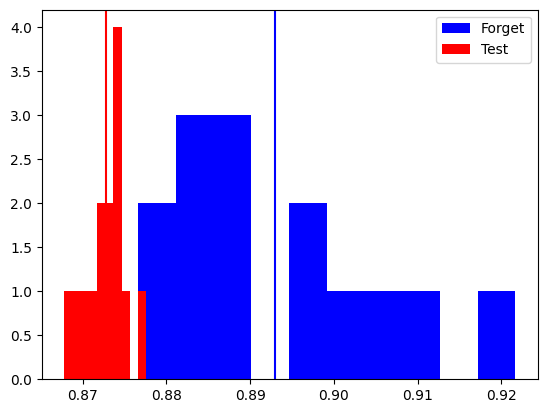

In [38]:
plt.hist(forget_accs, color='blue', label='Forget')
plt.axvline(x=np.mean(forget_accs), color='blue')
plt.hist(test_accs, color='red', label='Test')
plt.axvline(x=np.mean(test_accs), color='red')
plt.legend()
plt.show()

### KL

In [39]:
kl_losses = []
epsilon = 1e-2

for idx, original_loss in enumerate(original_losses):
    # losses_from_scratch = np.log(np.array(original_loss)/2 + epsilon)
    # losses_unlearn = np.log(np.array(unlearn_losses[idx]) + epsilon)

    # losses_from_scratch = np.random.lognormal(mean=losses_from_scratch.mean(), sigma=losses_from_scratch.std(), size=1000)
    # losses_unlearn = np.random.lognormal(mean=losses_unlearn.mean(), sigma=losses_unlearn.std(), size=1000)

    losses_from_scratch = np.array(original_loss)
    # losses_unlearn = np.array(unlearn_losses[idx])
    losses_unlearn = random.sample(unlearn_losses[idx], len(losses_from_scratch))

    # Ensure all losses are non-negative (they should naturally be if they are losses)
    # assert np.all(losses_from_scratch >= 0) and np.all(losses_unlearn >= 0), "Losses must be non-negative"

    # Normalize the losses to sum to one to represent probability distributions
    prob_dist_scratch = losses_from_scratch / np.sum(losses_from_scratch)
    prob_dist_unlearn = losses_unlearn / np.sum(losses_unlearn)

    # Compute the KL divergence (ensure no zero probability to avoid infinity)
    # Add a small constant to avoid division by zero or log of zero

    prob_dist_scratch += epsilon
    prob_dist_unlearn += epsilon

    # Normalize again after adding epsilon to ensure they sum to one
    prob_dist_scratch /= np.sum(prob_dist_scratch)
    prob_dist_unlearn /= np.sum(prob_dist_unlearn)

    # Calculate the KL divergence from scratch to unlearn
    kl_divergence = kl_div(prob_dist_scratch, prob_dist_unlearn)

    # Sum over all elements to get the total divergence
    total_kl_divergence = np.sum(kl_divergence)

    kl_losses.append(total_kl_divergence)

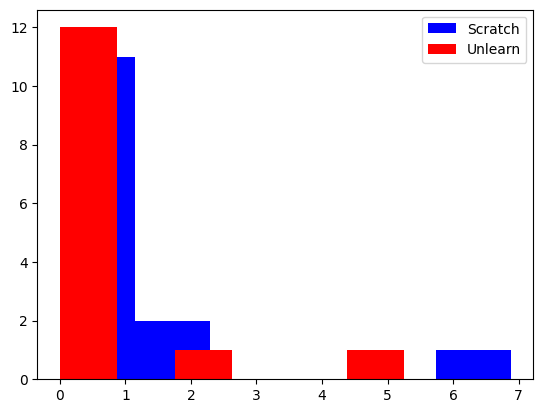

In [40]:
plt.hist(original_losses[2], bins=6, color='blue', label='Scratch')
plt.hist(unlearn_losses[2], bins=6, color='red', label='Unlearn')
# plt.xscale('log')
plt.legend()
plt.show()

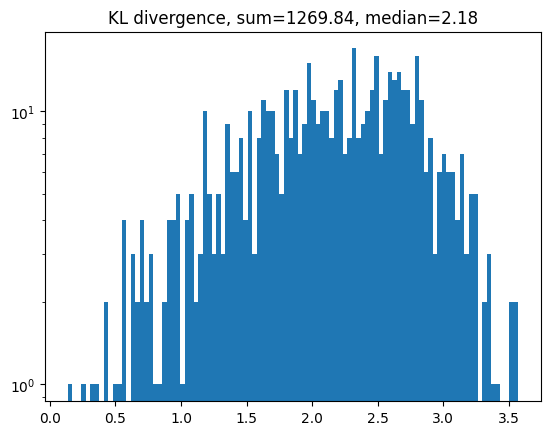

In [41]:
plt.hist(kl_losses, bins=100, log=True)
plt.title(f'KL divergence, sum={np.sum(kl_losses):.2f}, median={np.median(kl_losses):.2f}')
plt.show()

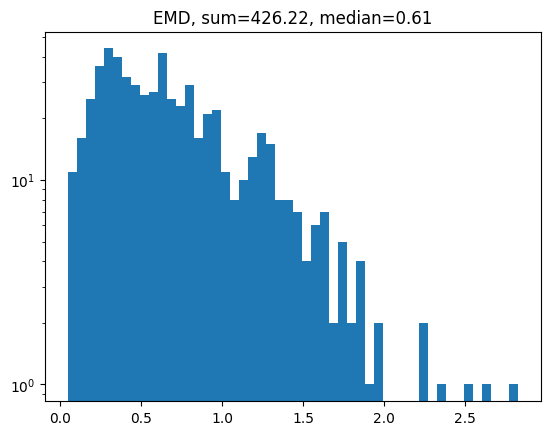

In [42]:
# Normalize losses, calculate standard deviation, and EMD per sample
emd_scores = []

for idx, original_loss in enumerate(original_losses):
    # normalized_losses = [ul / original_loss for ul in unlearn_losses[idx]]
    # std_dev = np.std(normalized_losses)
    
    # # Create a normal distribution for the original loss with the unlearned std deviation
    # original_distribution = np.random.lognormal(loc=original_loss, scale=std_dev, size=100)
   
    # # Use the normalized losses as the distribution of the unlearned model
    # unlearn_distribution = normalized_losses
   
    # Calculate Earth Mover's Distance
    emd_score = wasserstein_distance(original_loss, unlearn_losses[idx])
    emd_scores.append(emd_score)

plt.hist(emd_scores, bins=50, log=True)
plt.title(f'EMD, sum={np.sum(emd_scores):.2f}, median={np.median(emd_scores):.2f}');

In [43]:
# j = 0
# plt.hist(losses_from_scratch, color='blue', label='Trained from scratch')
# plt.axvline(x=np.mean(losses_from_scratch), color='blue')
# plt.hist(losses_unlearn, color='red', label='Unlearn')
# plt.axvline(x=np.mean(losses_unlearn), color='red')
# plt.yscale('log')
# plt.legend()
# plt.show()